# Group 3: Influential Superspreader Detection

In [37]:
# --- 1. Imports and Settings ---
import pandas as pd
import numpy as np
import networkx as nx
from datetime import timedelta
import matplotlib.pyplot as plt

# Settings
DATA_PATH = './COVID19_sample.csv'  # adjust if needed
NEWSGUARD_THRESHOLD = 39  # low-credibility threshold
DELTA_DAYS = 3          # time slot length
ALPHA = 0.5              # EMA smoothing factor

In [38]:
# --- 2. Load and Preprocess Data ---
df = pd.read_csv(DATA_PATH, parse_dates=['created_at'])

# Filter for low-credibility content
df = df[df['credibility_score'] <= NEWSGUARD_THRESHOLD]
# Remove self-reposts
df = df[df['user_id'] != df['retweeted_user_id']]

df.head()

,Unnamed: 0,tweet_id,created_at,user_id,retweeted_status_id,retweeted_user_id,credibility_score
8,17,1340503740433002496,2020-12-20 03:46:11+00:00,1277804951842979845,1340503265373466624,242880993,20.0
11,21,1340515040370278402,2020-12-20 04:31:05+00:00,1102714987787837445,1340503265373466624,242880993,20.0
13,24,1340519044961759232,2020-12-20 04:47:00+00:00,988373714,1340428826694852609,372937945,5.0
15,27,1340521034517241857,2020-12-20 04:54:54+00:00,140032760,1340324106487656449,726721856749842436,5.0
16,28,1340521296531218438,2020-12-20 04:55:57+00:00,69920939,1340503265373466624,242880993,20.0


In [39]:
# --- 3. Compute Influential Metric per User per Time Slot ---
def compute_influential_by_slot(df, start_date, end_date, delta):
    """
    Partition the data into time slots of length `delta` days and compute
    total re-posts per user in each slot.
    """
    slots = {}
    current_start = start_date
    slot_idx = 0
    while current_start < end_date:
        current_end = current_start + timedelta(days=delta)
        mask = (df['created_at'] >= current_start) & (df['created_at'] < current_end)
        sub = df[mask]
        counts = sub.groupby('retweeted_user_id').size()
        slots[slot_idx] = counts
        slot_idx += 1
        current_start = current_end
    return slots

min_date, max_date = df['created_at'].min(), df['created_at'].max()
slots = compute_influential_by_slot(df, min_date, max_date, DELTA_DAYS)
slots

{0: retweeted_user_id
 5893702                 2
 39941615                1
 82071060                1
 101717447               5
 104761548               8
                        ..
 1309160248914120705     3
 1322629376421355521    21
 1333778355716562944     1
 1337171273269522433     1
 1337542008429305866     6
 Length: 76, dtype: int64,
 1: retweeted_user_id
 24506538                 1
 96576495                 1
 107517248                1
 168732280                1
 228879550                2
 245969509                2
 283416650                1
 326150500               14
 332885533                1
 368878712                3
 376691595                1
 401438300                2
 486753729                2
 537079214                8
 910827588              115
 1032615842               8
 1035190398               1
 1176925574               3
 1189743062               1
 1198094372               2
 1527761478               9
 1673695388              53
 1683455144     

In [40]:
# --- 4. Exponential Moving Average of Influential Scores ---
def ema_scores(slots, alpha):
    times = sorted(slots.keys())
    # initialize the EMA with the first time slot
    ema = slots[times[0]].astype(float)

    # iterate through the remaining time slots
    for t in times[1:]:

        # reindex to ensure alignment and fill missing values with 0
        curr = slots[t].reindex(ema.index.union(slots[t].index), fill_value=0)

        # calculate the EMA for the current time slot
        ema = alpha * ema.reindex(curr.index, fill_value=0) \
              + (1 - alpha) * curr
        
    return ema

influential_ema = ema_scores(slots, ALPHA)
predicted_ranking = influential_ema.sort_values(ascending=False)
predicted_ranking

retweeted_user_id
1683455144             138.53125
1063806444380798976     52.87500
4394960301              38.75000
962681176526852096      33.12500
1131151171              26.75000
                         ...    
168732280                0.03125
221715205                0.03125
1261027260385169411      0.03125
39941615                 0.03125
24506538                 0.03125
Length: 269, dtype: float64

In [41]:
# --- 5. Build Low-Credibility Re-Share Network ---
# the Weight indicates the number of re-post from the original author to the user
G = nx.DiGraph()
for _, row in df.iterrows():
    u, v = row['retweeted_user_id'], row['user_id']
    G.add_edge(u, v, weight=G[u][v]['weight'] + 1 if G.has_edge(u, v) else 1)

total_weight = sum(d['weight'] for _, _, d in G.edges(data=True))

In [42]:
# --- 6. Network Dismantling Evaluation ---
# the percentage of prevented re-posts when removing the top K users
def network_dismantling(G, ranking, ks):
    qualities = {}
    for K in ks:
        removed = set(ranking.index[:K])
        prevented = sum(
            data['weight'] for u, v, data in G.edges(data=True)
            if u in removed or v in removed
        )
        qualities[K] = prevented / total_weight
    return qualities

# Compute ground truth for comparison, counting the number of re-posts per original author
ground_truth = df.groupby('retweeted_user_id').size().sort_values(ascending=False)
Ks = [5, 10, 20, 50]

quality_pred = network_dismantling(G, predicted_ranking, Ks)
quality_truth = network_dismantling(G, ground_truth, Ks)


In [43]:
# --- 7. Compute nDCG@K ---
from sklearn.metrics import ndcg_score

def compute_ndcg(pred_ranking, truth_ranking, K):
    # Get the top K users from truth_ranking
    users = list(truth_ranking.index[:K])

    # get the scores for these users in both rankings
    y_true = np.array([truth_ranking.get(u, 0) for u in users], dtype=float)
    y_score = np.array([pred_ranking.get(u, 0) for u in users], dtype=float)
    # Replace any NaNs
    y_true = np.nan_to_num(y_true)
    y_score = np.nan_to_num(y_score)
    return ndcg_score(y_true.reshape(1, -1), y_score.reshape(1, -1), k=K)

ndcg_pred = {K: compute_ndcg(predicted_ranking, ground_truth, K) for K in Ks}


    K  Quality_pred  Quality_truth      nDCG
0   5      0.332073       0.379917  1.000000
1  10      0.479955       0.524017  0.982102
2  20      0.658283       0.701210  0.972896
3  50      0.854576       0.877837  0.965385


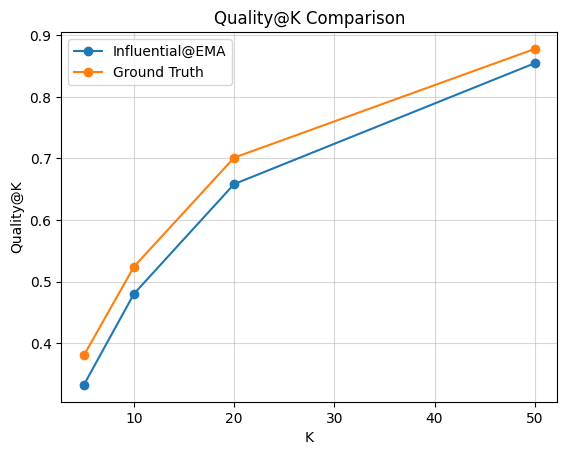

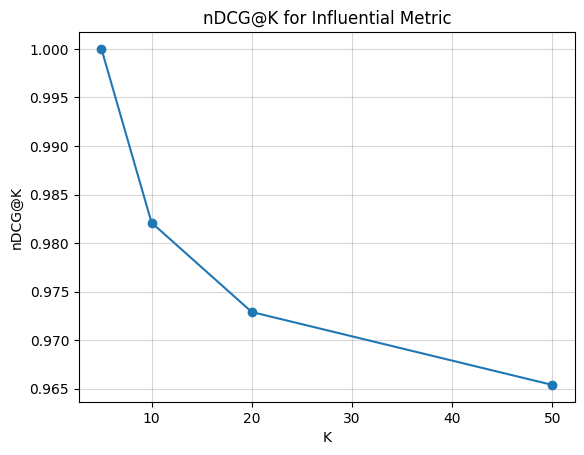

In [44]:
# --- 8. Results & Visualization ---
results = pd.DataFrame({
    'K': Ks,
    'Quality_pred': [quality_pred[K] for K in Ks],
    'Quality_truth': [quality_truth[K] for K in Ks],
    'nDCG': [ndcg_pred[K] for K in Ks]
})
print(results)

plt.figure()
plt.plot(results['K'], results['Quality_pred'], label='Influential@EMA', marker='o')
plt.plot(results['K'], results['Quality_truth'], label='Ground Truth', marker='o')
plt.xlabel('K'); plt.ylabel('Quality@K')
plt.grid(True, alpha=0.5)
plt.title('Quality@K Comparison'); plt.legend(); plt.show()

plt.figure()
plt.plot(results['K'], results['nDCG'], marker='o')
plt.xlabel('K'); plt.ylabel('nDCG@K')
plt.grid(True, alpha=0.5)
plt.title('nDCG@K for Influential Metric'); plt.show()